# COMP4318 & 5318 - Machine Learning and Data Mining: Assignment 1

Due: Sunday Week 7 - Sep 15th, 2024 11:59PM

### 1. Environment Setup

In [1]:
# TODO: Install and import necessary libraries
# General
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing/processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler # (?) might remove
from sklearn.decomposition import PCA
from skimage.feature import hog

# Models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Evaluation & Finetuning
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, mean_absolute_error, accuracy_score

In [2]:
# TODO: Define helper function (e.g. plotting) if applicable

def get_hog_features(row, image_shape=(28, 28)):
    # Step 1: Reshape the flattened row (1D array) back to 2D
    reshaped_image = row.values.reshape(image_shape)
    
    # Step 2: Apply HOG feature extraction
    hog_features = hog(reshaped_image, 
                       orientations=16, 
                       pixels_per_cell=(3, 3),
                       cells_per_block=(2, 2), 
                       block_norm='L2-Hys', 
                       visualize=False)
    return hog_features

#set seed
seed = 2307

# Label mapping for visualization
label_mapping = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 2. Data Preprocessing

In [3]:
# TODO: Implement Preprocessing Techniques

# Read file
pd.options.mode.chained_assignment = None
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test1.csv')
df_test_kaggle = pd.read_csv('data/test2.csv')

# Seperate features and labels
X = df.loc[:, "v1":"v784"]
Y = df.loc[:, "label"]
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=seed)

X_test = df_test.loc[:, "v1":"v784"]
Y_test = df_test.loc[:, "label"]
X_kaggle = df_test_kaggle.loc[:, "v1":"v784"]

# Normalization
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
X_kaggle = X_kaggle/255

# Histogram of Oriented Gradients (HOG)
X_train_hog = pd.DataFrame(X_train.apply(get_hog_features, axis=1).tolist())
X_val_hog = pd.DataFrame(X_val.apply(get_hog_features, axis=1).tolist())
X_test_hog = pd.DataFrame(X_test.apply(get_hog_features, axis=1).tolist())
X_kaggle_hog = pd.DataFrame(X_kaggle.apply(get_hog_features, axis=1).tolist())

# Dimensionality reduction using PCA
#pca = PCA(n_components=0.99, random_state=seed)
#X_train_hog_pca = pca.fit_transform(X_train_hog_df)
#X_test_hog_pca = pca.transform(X_test_hog_df)


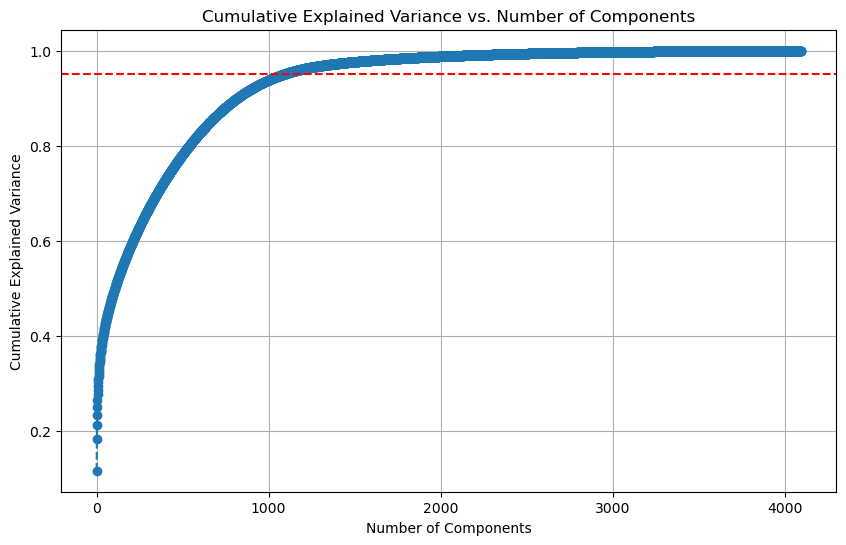

Number of components to maintain 95% variance: 1084


In [4]:
## Dimensionality reduction using PCA
pca = PCA(random_state=seed)
pca.fit(X_train_hog)

# Plot the cumulative variance ratio (cvr) vs number of PCs
evr = pca.explained_variance_ratio_ 
cvr = np.cumsum(evr)

plt.figure(figsize=(10, 6))
plt.plot(cvr, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Find the number of components that maintain 95% of the variance
n_components_95 = np.argmax(cvr >= 0.95) + 1
print(f'Number of components to maintain 95% variance: {n_components_95}')

# Return new training and test data 
pca = PCA(n_components = n_components_95)
X_train_pca, X_val_pca, X_test_pca, X_kaggle_pca = pca.fit_transform(X_train_hog), pca.fit_transform(X_val_hog), pca.transform(X_test_hog), pca.transform(X_kaggle_hog)

### 3.1. Model 1 - KNN

#### Base Implementation

In [5]:
# TODO: Implement model 1 
base_knn = KNeighborsClassifier()

# Fit kNN
start_time = time.time()
base_knn.fit(X_train_pca, Y_train)
end_time = time.time()
print(f"Time to fit kNN: {end_time - start_time:.2f} seconds")

# Predict and evaluate on validation data
Y_pred_knn = base_knn.predict(X_val_pca)
accuracy = accuracy_score(Y_val, Y_pred_knn)
print(f"kNN Accuracy: {accuracy:.3f}")

#Time to fit kNN: 0.32 seconds
#Time to predict with kNN: 3.66 seconds
#kNN Accuracy:, 0.849

Time to fit kNN: 0.16 seconds
kNN Accuracy: 0.730


#### Hyper-parameters Tuning

In [11]:
knn = KNeighborsClassifier()

# Define the parameter grid
param_grid = {
    'n_neighbors': np.arange(1, 21),  # Number of neighbors to try (from 1 to 20)
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]  # Power parameter for the Minkowski distance (1 is Manhattan, 2 is Euclidean)
}

# Set up GridSearchCV
knn_cv = GridSearchCV(
    knn, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy', 
    verbose=2
)

# Fit knn model
start_time = time.time()
knn_cv.fit(X_train_pca, Y_train)
end_time = time.time()

# Print the best parameters and the best score
print(f"Best parameters: {knn_cv.best_params_}")
print(f"Best cross-validation accuracy: {knn_cv.best_score_:.2f}")

total_fits = len(knn_cv.cv_results_['mean_test_score']) * knn_cv.cv
knn_training_time = (start_time-end_time)/total_fits

# Predict on test data
best_knn = knn_cv.best_estimator_
Y_pred_knn = best_knn.predict(X_val_pca)

# Evaluate the model
accuracy = accuracy_score(Y_val, Y_pred_knn)
print(f"kNN Accuracy: {accuracy:.3f}")

### 3.2. Model 2 - SVM

#### Base Implementation

In [7]:
# TODO: Implement model 2
base_svm = SVC(random_state = seed)

# Fit SVM model
start_time = time.time()
base_svm.fit(X_train_pca, Y_train)
end_time = time.time()
print(f"Time to fit SVM: {end_time - start_time:.2f} seconds")

# Predict and evaluate on validation data
Y_pred_svm = base_svm.predict(X_val_pca)
accuracy = accuracy_score(Y_val, Y_pred_svm)
print(f"SVM Accuracy: {accuracy:.3f}")

Time to fit SVM: 74.80 seconds
SVM Accuracy: 0.776


#### Hyper-parameters Tuning

In [13]:
# Finetune hyperparameters using gridsearch and k-fold cross validation
svm = SVC(kernel='rbf',
         random_state = seed)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.01, 0.1, 1, 10]   # Regularisation parameter for SVM
}

# Set up GridSearchCV
svm_cv = GridSearchCV(
    svm, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy', 
    verbose=2
)

# Fit knn model
start_time = time.time()
svm_cv.fit(X_train_pca, Y_train)
end_time = time.time()

# Print the best parameters and the best score
print(f"Best parameters: {svm_cv.best_params_}")
print(f"Best cross-validation accuracy: {svm_cv.best_score_:.2f}")

total_fits = len(svm_cv.cv_results_['mean_test_score']) * svm_cv.cv
svm_training_time = (start_time-end_time)/total_fits

# Predict on test data
best_svm = svm_cv.best_estimator_
Y_pred_svm = best_svm.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred_svm)
print(f"SVM Accuracy: {accuracy:.3f}")

In [ ]:
# Finer hyperparameter tuning
start_time = time.time()

svm = SVC(kernel='rbf',
         random_state = seed)

# Define the parameter grid
param_grid = {
    'C': np.arange(5, 16, 2),
    'gamma': np.arange(0.005, 0.016, 0.002)   # Regularisation parameter for SVM
}

# Set up GridSearchCV
svm_cv = GridSearchCV(
    svm, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy', 
    verbose=2
)

# Fit knn model
start_time = time.time()
svm_cv.fit(X_train_pca, Y_train)
end_time = time.time()

# Print the best parameters and the best score
print(f"Best parameters: {svm_cv.best_params_}")
print(f"Best cross-validation accuracy: {svm_cv.best_score_:.2f}")

total_fits = len(svm_cv.cv_results_['mean_test_score']) * svm_cv.cv
svm_training_time = (start_time-end_time)/total_fits

# Predict on test data
best_svm = svm_cv.best_estimator_
Y_pred_svm = best_svm.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred_svm)
print(f"SVM Accuracy: {accuracy:.3f}")

end_time = time.time()
print(f"Cell completion time: {end_time - start_time:.2f} seconds")

### 3.3. Model 3 - Decision Tree

#### Base Implementation

In [8]:
# TODO: Implement model 3
# Decision Tree
base_dt = DecisionTreeClassifier(criterion='gini', 
                             splitter='best',
                             random_state=seed)

# Fit model
start_time = time.time()
base_dt.fit(X_train_pca, Y_train)
end_time = time.time()
print(f"Time to fit Decision Tree: {end_time - start_time:.2f} seconds")

# Predict and evaluate on validation data
Y_pred_dt = base_dt.predict(X_val_pca)
accuracy = accuracy_score(Y_val, Y_pred_dt)
print(f"Decision Tree Validation Accuracy: {accuracy:.3f}")
#Y_pred_train = clf_dt.predict(X_train_pca)
#print("Train Accuracy:", accuracy_score(Y_train, Y_pred_train))

Time to fit Decision Tree: 49.75 seconds
Decision Tree Validation Accuracy: 0.674


#### Hyper-parameters Tuning

In [15]:
# Finetune hyperparameters using gridsearch and k-fold cross validation
dt = DecisionTreeClassifier(splitter='best',
                            min_impurity_decrease=0, 
                            class_weight=None, 
                            #ccp_alpha=0.001,
                            random_state=seed)

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}

# Set up GridSearchCV
dt_cv = GridSearchCV(
    dt, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy', 
    verbose=2
)

# Fit knn model
start_time = time.time()
dt_cv.fit(X_train_pca, Y_train)
end_time = time.time()

# Print the best parameters and the best score
print(f"Best parameters: {dt_cv.best_params_}")
print(f"Best cross-validation accuracy: {dt_cv.best_score_:.2f}")

total_fits = len(dt_cv.cv_results_['mean_test_score']) * dt_cv.cv
dt_training_time = (start_time-end_time)/total_fits

# Predict on test data
best_dt = dt_cv.best_estimator_
Y_pred_dt = best_dt.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred_svm)
print(f"SVM Accuracy: {accuracy:.3f}")

### 3.4. Model 4 - XGBoost

#### Base Implementation

In [ ]:
# TODO: Implement model 4
# XGBoost
base_xgb = xgb.XGBClassifier(objective="multi:softmax",
                          tree_method="approx",
                          eval_metric="mlogloss",
                          random_state = seed)

start_time = time.time()
base_xgb.fit(X_train_pca, Y_train)
end_time = time.time()
print(f"Time to fit XGBoost: {end_time - start_time:.2f} seconds")

Y_pred_xgb = base_xgb.predict(X_val_pca)
accuracy = accuracy_score(Y_val, Y_pred_xgb)
print(f"XGBoost Validation Accuracy: {accuracy:.3f}")
#Y_pred_train = clf_xgb.predict(X_train)
#print("Train Accuracy:", accuracy_score(Y_train, Y_pred_train))

#### Hyper-parameters Tuning

In [17]:
# Finetune hyperparameters using gridsearch and k-fold cross validation
start_time = time.time()

xgb = xgb.XGBClassifier(objective="multi:softmax",
                       tree_method="approx",
                       eval_metric="mlogloss",
                       learning_rate=0.3,
                       random_state = seed)

# Define the parameter grid
param_grid = {
    'max_depth':[3, 4, 5], 
    'n_estimators':[100, 150, 200],
    'reg_lambda': [0, 100]
}

# Set up GridSearchCV
xgb_cv = GridSearchCV(
    xgb, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy', 
    verbose=2
)

# Fit knn model
start_time = time.time()
xgb_cv.fit(X_train_pca, Y_train)
end_time = time.time()

# Print the best parameters and the best score
print(f"Best parameters: {xgb_cv.best_params_}")
print(f"Best cross-validation accuracy: {xgb_cv.best_score_:.2f}")

total_fits = len(svm_cv.cv_results_['mean_test_score']) * svm_cv.cv
svm_training_time = (start_time-end_time)/total_fits

end_time = time.time()
print(f"Cell completion time: {end_time - start_time:.2f} seconds")

### 3.5. Evaluation

Evaluate the best version of each model using appropriate classification performance metrics on the validation set and test on `test1.csv`. Ensure that the results are visualized using high-quality plots, figures, or tables to clearly demonstrate model performance.

In [18]:
# TODO: Evaluate each model

# Predict on test data
best_knn = knn_cv.best_estimator_
best_svm = svm_cv.best_estimator_
best_dt = dt_cv.best_estimator_
best_xgb = xgb_cv.best_estimator_

models = [best_knn, best_svm, best_dt, best_xgb]
model_names = ['KNN', 'SVM', 'DT', 'XGBoost']
val_accuracy = []
test_accuracy = []
inference_time = []

# Get accuracy
for model in models:
    Y_val_pred = model.predict(X_val_pca)
    val_accuracy.append(accuracy_score(Y_val, Y_val_pred))

    start_time = time.time()
    Y_test_pred = model.predict(X_test_pca)
    test_accuracy.append(accuracy_score(Y_test, Y_test_pred))
    end_time = time.time()
    
    inference_time.append((end_time-start_time)/len(Y_test))

bar_width = 0.35
x_pos = np.arange(len(models))

# Plot Model Accuracy
plt.figure(figsize=(10, 6))
plt.bar(x_pos - bar_width/2, val_accuracy, width=bar_width, label='Validation Accuracy', color='skyblue')
plt.bar(x_pos + bar_width/2, test_accuracy, width=bar_width, label='Test Accuracy', color='lightgreen')
plt.title('Model Accuracy on Validation and Test Data', fontsize=16)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(x_pos, model_names)
plt.show()

# Plot Inference Time
plt.figure(figsize=(10, 6))
plt.bar(model_names, inference_time, color='skyblue')
plt.title('Model Mean Inference time')
plt.xlabel('Model')
plt.ylabel('Time (s)')
plt.grid(True)
plt.show()

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred_svm)
print(f"SVM Accuracy: {accuracy:.3f}")

### 4.1. Comparison

Compare all classifiers with their optimized hyper-parameters, focusing on criteria such as classification performance, training time, and inference time. Visualization of these comparisons is required; use high-quality plots, figures, or tables to facilitate a clear understanding of the differences and strengths of each model.

In [19]:
# TODO: Compare performance of all models

### 4.2. The Best Classifier

Conclude the best classifier

In [1]:
# TODO: Train and test the classifier which has the best performance

### 5. Predict on Kaggle Test Data

Load the testing data for prediction

In [6]:
# test2.csv includes 5000 samples used for label prediction. Test samples do not have labels.
data_test_df = pd.read_csv('./data/test2.csv', index_col=0)

Use the your best classifier to make predictions for the test data. The predictions should be stored in a vector named `output`, with a length of 5000.

In [23]:
# TODO: Use your best classifier to make predictions on unseen data. The output of this code must be a vector named 'output' of length 5000

Save your prediction vector as a `test_output.csv` file, which contains two columns: `id` and `label`. Please refer to the `example_output.csv` for the structure of this output file. 

In [ ]:
output_df = pd.DataFrame(output, columns = ['label'])
output_df.to_csv('./test_output.csv', sep=",", float_format='%d',index_label="id")